# Workflow



- Load presets
- Max uncertainty <= 0.2?
    1. Load data
    2. Train GP model
    3. Initial Sampling on locations (different algorithms applied here)
    4. Evaluate and find maximum uncertainty within limited frame (optimal exploration)
    5. Adaptively select location sets
    6. run zCFD simulation
    7. merge data back to dataset
- Repeat
- Output model


5 turbine - 24h
The aim is to fine tune model with minimum cost. Therefore adaptive learning and different generative methods were used and improve the model by iterative data augmentation methods.

During research, I've tried out naive approach - randomly generate 1000 locations and evaluate the uncertainty; Genetic Algorithm; Particle Swarm Optimisation; Hybrid PSO-GA method; Simulated Annealing (mh)


# Load Presets

In [49]:
# Load modules
import cfd_simulate
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import three_desc_model as exponential_new
from itertools import combinations
from cutoffs import Polynomial
import GP_functions1 as GP
from GP_functions1 import TurbineUtility
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [50]:

import GPy
from IPython.display import display
GPy.plotting.change_plotting_library('matplotlib')

In [51]:
#Set up neighbourlist calculation
# USE NEW CLASSES
turbine_utility = TurbineUtility()
nl = turbine_utility.nl
nl=exponential_new.NeighborlistCalculator(cutoff=4001,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
symbol="Siemens"
turb = [symbol]

# Load data

In [52]:
dataset_full = pd.read_csv('all_dataset.csv', index_col=0)
symbol="Siemens"
k=0
count=0
dataset_full["IDnum"]=pd.Series()
for i in range(len(dataset_full)):
    dataset_full.at[i,"IDnum"]=k
    count = count +1
    if (count==dataset_full["Num_tot_turb"].iloc[i]):
        k=k+1
        count=0
dataset_full["Num_tot_turb"]=dataset_full["Num_tot_turb"].astype(int)
dataset_full["Turb_num"]=dataset_full["Turb_num"].astype(int)
dataset_full["IDnum"]=dataset_full["IDnum"].astype(int)
numsims=dataset_full["IDnum"].iloc[-1]+1
turb = [symbol]


 /tmp/ipykernel_170399/3090405090.py:5: FutureWarning:The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [53]:
nl=exponential_new.NeighborlistCalculator(cutoff=4001,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
Gs = {"Siemens": [{"type":"G2", "turbine":"Siemens","eta":4.25387599, "offset": 1.0151402},
                  {"type":"G4", "elements":"Siemens","eta":2.56450515, "gamma":8.04475192, "zeta": 2.5356155},
                  {"type":"G6", "elements":"Siemens","eta":2.33043463, "gamma": 0.50753377, "zeta": 0.93372721},
                  
                 ]}
finpr=exponential_new.FingerprintCalculator(cutoff=4001,Gs=Gs,Rct=3000,delta_R=100,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
count=0
dataset_fp=np.empty(shape=(0, 3))
dataset_ws=np.empty(shape=(0, 1))
dataset_pos=np.empty(shape=(0, 2))
for i in range(numsims):
    numturb=dataset_full["Num_tot_turb"].iloc[count]
    position = np.empty((numturb,2))
    ws = np.empty((numturb,1))
    fp = np.empty((numturb,3))
    for k in range(numturb):
        position[k,0]=dataset_full.at[count,"X_coord"]
        position[k,1]=dataset_full.at[count,"Y_coord"]
        ws[k,0]=dataset_full.at[count,"Ref_wind"]
        count = count+ 1
    neigh=nl.calculate(turb*numturb,position)
    fingerprints=finpr.calculate(turb*numturb,position,neigh,symbol)
    fingerprints=np.array(fingerprints)
    dataset_fp=np.append(dataset_fp,fingerprints,axis=0)
    dataset_ws=np.append(dataset_ws,ws,axis=0)
    dataset_pos=np.append(dataset_pos,position,axis=0)
dataset=np.concatenate((dataset_fp, dataset_ws),axis=1)
dataset = pd.DataFrame(dataset, columns = ['Fingerprint(G2)','Fingerprint(G4)','Fingerprint(G6)','Ref_Wind_Speed'])
X=dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Y=dataset[["Ref_Wind_Speed"]].to_numpy()
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
Xtrain=train_dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Ytrain=train_dataset[["Ref_Wind_Speed"]].to_numpy()
Xtest=test_dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Ytest=test_dataset[["Ref_Wind_Speed"]].to_numpy()

# Train GP

In [29]:
ker = GPy.kern.RBF(3,lengthscale=0.1)# + GPy.kern.White(2)

In [30]:
# m = GPy.models.SparseGPRegression(Xtrain,Ytrain,ker)
m = GPy.models.GPRegression(Xtrain,Ytrain,ker)

In [31]:
m.optimize(messages=True,max_f_eval = 1000)


# Original approach

In [54]:
# Constants
min_dist = 279.0
max_xdist = 4000
max_width = 500
numturb = 5

In [55]:
while True:
    # Generate random coordinates
    turbines = np.zeros([numturb,2])
    for i in range(1,numturb):
        # X coordinate from triangular distribution (mode 0)
        turbines[i,0]=np.random.triangular(0,0,max_xdist)
        # y coordinate from triangular distribution (mode 0)
        turbines[i,1]=np.random.triangular(-max_width,0,max_width)
    print('Turbine Locations: ', turbines)
    neigh=nl.calculate(turb*numturb,turbines)
    fingerprints=np.array(finpr.calculate(turb*numturb,turbines,neigh,symbol))
    refwind,refstdev=m.predict(fingerprints)
    print('Neighbours: ', neigh)

    
    for i in range(numturb):
        if (len(neigh[i])==numturb-1):
            
            # if one of them has maximal number of neigbours: break loop

            break
    else:
        # If none of them has maximal number of neighbours: Try again
        print("Not enough neighbours")
        continue
    # Check distances
    for i, j in combinations(range(numturb), 2):
        if (np.linalg.norm(turbines[i]-turbines[j])<min_dist):
            # Two turbines are too close
            print("Distance between turbine ",i+1," and turbine ",j+1," is too low.")
            break
    else:
        # None of the turbines are too close: SUCCESS!
        break

    uncertainty_threshold = np.percentile(refstdev, 90)  # 90% threshold
    if np.all(refstdev < uncertainty_threshold):
        break
    else:
        print("Uncertainties are too high, trying again.")
        continue
    


Turbine Locations:  [[   0.            0.        ]
 [3194.58911279  298.32122359]
 [2752.07917801  -33.96991841]
 [2583.03446281   83.50782744]
 [2588.65566346 -131.55185775]]
Neighbours:  [[], [0], [0], [0], [0]]
Not enough neighbours
Turbine Locations:  [[   0.            0.        ]
 [ 973.61071282  309.56811937]
 [  12.73395377 -263.85204862]
 [1889.87919896  174.89327452]
 [1291.58905556 -215.29183641]]
Neighbours:  [[], [], [], [0, 1], [0, 2]]
Not enough neighbours
Turbine Locations:  [[   0.            0.        ]
 [ 663.5881034   195.61365726]
 [ 928.12126785 -335.9051743 ]
 [1188.50868796   54.29032143]
 [2874.91329975   63.52549093]]
Neighbours:  [[], [], [], [0], [0, 1, 3]]
Not enough neighbours
Turbine Locations:  [[   0.            0.        ]
 [ 964.1894817    90.60710772]
 [  80.40223601  -48.01896357]
 [2118.63275689  277.26374402]
 [ 276.26278405 -162.79642059]]
Neighbours:  [[], [0, 2], [0], [0, 1, 2], []]
Not enough neighbours
Turbine Locations:  [[   0.            0

## Visualise

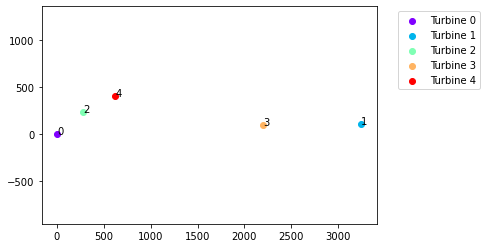

In [64]:
numturb = turbines.shape[0]

cmap = plt.get_cmap('rainbow', numturb)

for i in range(numturb):
    plt.scatter(turbines[i,0], turbines[i,1], color=cmap(i), label='Turbine ' + str(i))

# Set the desired limits for the x and yaxes
plt.xlim(-300, 4500)
plt.ylim(-500, 500)
plt.axis('equal')

# Add labels to each point
for i in range(numturb):
    plt.text(turbines[i, 0], turbines[i, 1], str(i))

# Add legends
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()




# Evaluation function

In [21]:
min_threshold = 5 # Valid numbers
max_threshold = 25

In [22]:
def calculate_power_output(refwind, min_threshold, max_threshold):
    total_power = np.sum(refwind)
    individual_scores = np.where((refwind >= min_threshold) & (refwind <= max_threshold), refwind, 0)
    fitness = total_power + np.sum(individual_scores)
    return fitness

# Naive approach

In [65]:
from scipy.optimize import minimize

In [66]:
# Initial Sampling
def initial_sampling(num_samples):
    samples = []
    while len(samples) < num_samples:
        turbines = np.zeros((numturb, 2))
        for i in range(1, numturb):
            turbines[i, 0] = np.random.triangular(0, 0, max_xdist)
            turbines[i, 1] = np.random.triangular(-max_width, 0, max_width)
        
        # Check distances
        valid = True
        for i, j in combinations(range(numturb), 2):
            if np.linalg.norm(turbines[i] - turbines[j]) < min_dist:
                valid = False
                break
        
        if valid:
            samples.append(turbines)
    return np.array(samples)

def acquisition_function(X, model):
    X = X.reshape(1, -1)
    mu, sigma = model.predict(X)
    return sigma

def optimise_acquisition(model):
    best_x = None
    best_acq_value = -np.inf

    initial_samples = initial_sampling(100)  # Generate initial samples, 100 to save space
    for turbines in initial_samples:
        turbines_flat = turbines.flatten()
        res = minimize(lambda x: -acquisition_function(x, model), turbines_flat, bounds=[(0, max_xdist)]*numturb*2)
        acq_value = -res.fun
        if acq_value > best_acq_value:
            best_acq_value = acq_value
            best_x = res.x

    return best_x.reshape(numturb, 2)

In [67]:
turbine_locations = optimise_acquisition(m)
print("Best Location with Maximum Uncertainty:")
print(turbine_locations)


Best Location with Maximum Uncertainty:
[[0.00000000e+00 0.00000000e+00]
 [1.54058499e+03 1.77161734e+02]
 [9.24209525e+02 0.00000000e+00]
 [5.77795468e+02 5.61579263e-01]
 [3.01720834e+03 0.00000000e+00]]


In [68]:
neighna = nl.calculate(turb * numturb, turbine_locations)
fingerprints = np.array(finpr.calculate(turb * numturb, turbine_locations, neighna, symbol))
refwindna, refstdevna = m.predict(fingerprints)



In [69]:
print('Optimised Power Output: ', calculate_power_output(refwindna, min_threshold, max_threshold))
print('Optimised Uncertainty: ', refstdevna)
print('Optimised Total Uncertainty: ', np.sum(refstdevna))

print('Optimised Wind Speed: ', refwindna)


Optimised Power Output:  49.56017781506631
Optimised Uncertainty:  [[0.00666389]
 [0.00716671]
 [0.23235084]
 [0.00783342]
 [0.23088845]]
Optimised Total Uncertainty:  0.48490330344042454
Optimised Wind Speed:  [[7.39826054]
 [7.39092943]
 [4.15152462]
 [5.47199842]
 [4.88627642]]


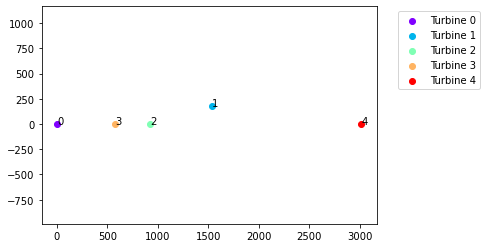

In [70]:
numturb = turbine_locations.shape[0]

cmap = plt.get_cmap('rainbow', numturb)

for i in range(numturb):
    plt.scatter(turbine_locations[i,0], turbine_locations[i,1], color=cmap(i), label='Turbine ' + str(i))

# Set the desired limits for the x and yaxes
plt.xlim(-300, 4500)
plt.ylim(-500, 500)
plt.axis('equal')

# Add labels to each point
for i in range(numturb):
    plt.text(turbine_locations[i, 0], turbine_locations[i, 1], str(i))

# Add legends
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()




# Methodology 

## Genetic Algorithm (GA)

Genetic Algorithm (GA) is a population-based optimization technique inspired by the process of natural selection. It operates through selection, crossover, and mutation operators to evolve a population of candidate solutions towards better solutions.

1. **Initialisation:**
   - Initialise a population of `m` individuals with random solutions.
   - Define the objective function $ f(x) $ to be minimised.

2. **Selection:**
   - Select pairs of individuals from the population based on their fitness (objective function value). The probability of selection is often based on the relative fitness of the individuals (e.g., roulette wheel selection).

3. **Crossover:**
   - Perform crossover (recombination) on selected pairs to generate offspring. A common crossover method is single-point crossover, where a random crossover point is selected, and the offspring are created by exchanging genetic material (solution components) at that point.

4. **Mutation:**
   - Apply mutation to the offspring with a certain probability. Mutation introduces random changes to the solution components to maintain genetic diversity and explore new regions of the search space.

5. **Replacement:**
   - Replace the old population with the new population of offspring.

6. **Termination:**
   - Repeat the selection, crossover, mutation, and replacement steps until a stopping criterion is met (e.g., a maximum number of generations or a satisfactory error threshold).


### GA model train

In [9]:
dataset_full = pd.read_csv('all_dataset_ga.csv')
symbol="Siemens"
k=0
count=0
dataset_full["IDnum"]=pd.Series()
for i in range(len(dataset_full)):
    dataset_full.at[i,"IDnum"]=k
    count = count +1
    if (count==dataset_full["Num_tot_turb"].iloc[i]):
        k=k+1
        count=0
print(dataset_full)

 /tmp/ipykernel_170399/4095865798.py:5: FutureWarning:The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


          X_coord     Y_coord  Ref_wind  Num_tot_turb  \
0        0.000000    0.000000  7.479762             2   
1      241.621088  139.500000  7.576231             2   
2        0.000000    0.000000  7.473602             2   
3      244.018898  135.261884  7.567527             2   
4        0.000000    0.000000  7.467848             2   
...           ...         ...       ...           ...   
1799     0.000000    0.000000  7.262725             5   
1800   619.718747  267.898323  5.354641             5   
1801   926.446721  302.922380  4.038991             5   
1802   126.933447  303.084213  7.232605             5   
1803  2682.551366  248.657732  5.816997             5   

                                      ID  Turb_num  IDnum  
0     2_turbine_240_degrees_279.0_meters         0    0.0  
1     2_turbine_240_degrees_279.0_meters         1    0.0  
2     2_turbine_241_degrees_279.0_meters         0    1.0  
3     2_turbine_241_degrees_279.0_meters         1    1.0  
4     2_turbine

In [56]:
dataset_full = pd.read_csv('all_dataset_ga.csv')
symbol="Siemens"
k=0
count=0
dataset_full["IDnum"]=pd.Series()
for i in range(len(dataset_full)):
    dataset_full.at[i,"IDnum"]=k
    count = count +1
    if (count==dataset_full["Num_tot_turb"].iloc[i]):
        k=k+1
        count=0
dataset_full["Num_tot_turb"]=dataset_full["Num_tot_turb"].astype(int)
dataset_full["Turb_num"]=dataset_full["Turb_num"].astype(int)
dataset_full["IDnum"]=dataset_full["IDnum"].astype(int)
numsims=dataset_full["IDnum"].iloc[-1]+1
turb = [symbol]


 /tmp/ipykernel_170399/853801795.py:5: FutureWarning:The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [57]:
nl=exponential_new.NeighborlistCalculator(cutoff=4001,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
Gs = {"Siemens": [{"type":"G2", "turbine":"Siemens","eta":4.25387599, "offset": 1.0151402},
                  {"type":"G4", "elements":"Siemens","eta":2.56450515, "gamma":8.04475192, "zeta": 2.5356155},
                  {"type":"G6", "elements":"Siemens","eta":2.33043463, "gamma": 0.50753377, "zeta": 0.93372721},
                  
                 ]}
finpr=exponential_new.FingerprintCalculator(cutoff=4001,Gs=Gs,Rct=3000,delta_R=100,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
count=0
dataset_fp=np.empty(shape=(0, 3))
dataset_ws=np.empty(shape=(0, 1))
dataset_pos=np.empty(shape=(0, 2))
for i in range(numsims):
    numturb=dataset_full["Num_tot_turb"].iloc[count]
    position = np.empty((numturb,2))
    ws = np.empty((numturb,1))
    fp = np.empty((numturb,3))
    for k in range(numturb):
        position[k,0]=dataset_full.at[count,"X_coord"]
        position[k,1]=dataset_full.at[count,"Y_coord"]
        ws[k,0]=dataset_full.at[count,"Ref_wind"]
        count = count+ 1
    neigh=nl.calculate(turb*numturb,position)
    fingerprints=finpr.calculate(turb*numturb,position,neigh,symbol)
    fingerprints=np.array(fingerprints)
    dataset_fp=np.append(dataset_fp,fingerprints,axis=0)
    dataset_ws=np.append(dataset_ws,ws,axis=0)
    dataset_pos=np.append(dataset_pos,position,axis=0)
dataset=np.concatenate((dataset_fp, dataset_ws),axis=1)
dataset = pd.DataFrame(dataset, columns = ['Fingerprint(G2)','Fingerprint(G4)','Fingerprint(G6)','Ref_Wind_Speed'])
X=dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Y=dataset[["Ref_Wind_Speed"]].to_numpy()
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
Xtrain=train_dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Ytrain=train_dataset[["Ref_Wind_Speed"]].to_numpy()
Xtest=test_dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Ytest=test_dataset[["Ref_Wind_Speed"]].to_numpy()

In [58]:
ker = GPy.kern.RBF(3,lengthscale=0.1)# + GPy.kern.White(2)

In [59]:
# m = GPy.models.SparseGPRegression(Xtrain,Ytrain,ker)
m_ga = GPy.models.GPRegression(Xtrain,Ytrain,ker)

In [60]:
m_ga.optimize(messages=True,max_f_eval = 1000)


In [61]:
from sklearn.metrics import pairwise_distances


In [62]:
min_dist = 279.0
bounds = [(0, 0), (4000, 500)] # 0,0 as initial, 4000,500 as field


In [63]:
def fitness_function(turbines, min_dist):
    numturb = turbines.shape[0]
    distances = pairwise_distances(turbines)
    np.fill_diagonal(distances, np.inf)  # Don't consider the distance to itself
    
    if np.any(distances < min_dist):
        return -np.inf  # Penalize solutions with close turbines
    
    neigh = nl.calculate(['Siemens'] * numturb, turbines)  # Calculate neighbours
    fingerprints = np.array(finpr.calculate(['Siemens'] * numturb, turbines, neigh, 'Siemens'))
    _, refstdev = m_ga.predict(fingerprints)
    total_uncertainty = np.sum(refstdev)
    return total_uncertainty

def generate_population(pop_size, num_turb, bounds):
    population = np.random.uniform(bounds[0], bounds[1], (pop_size, num_turb, 2))
    population[:, 0, :] = 0  # Fix the first turbine at (0, 0)
    return population

def mutate(individual, bounds, mutation_rate=0.1):
    for i in range(1, individual.shape[0]):  # Start from 1 to skip the first turbine
        if np.random.rand() < mutation_rate:
            individual[i, 0] = np.random.uniform(bounds[0][0], bounds[1][0])
            individual[i, 1] = np.random.uniform(bounds[0][1], bounds[1][1])
    return individual

def crossover(parent1, parent2):
    num_turb = parent1.shape[0]
    point = np.random.randint(1, num_turb)
    child = np.vstack((parent1[:point], parent2[point:]))
    child[0] = parent1[0]  # Ensure the first turbine stays at (0, 0)
    return child

def select(population, fitnesses, num_parents):
    parents = np.empty((num_parents, population.shape[1], 2))
    for parent_num in range(num_parents):
        max_fitness_idx = np.where(fitnesses == np.max(fitnesses))[0][0]
        parents[parent_num, :, :] = population[max_fitness_idx, :, :]
        fitnesses[max_fitness_idx] = -999999
    return parents

def genetic_algorithm(bounds, min_dist, num_turb, pop_size, num_generations):
    population = generate_population(pop_size, num_turb, bounds)
    best_output = []
    
    for generation in range(num_generations):
        print(f"Generation {generation}")
        fitnesses = np.array([fitness_function(individual, min_dist) for individual in population])
        
        best_output.append(np.max(fitnesses))
        print(f"Best fitness: {np.max(fitnesses)}")
        
        parents = select(population, fitnesses, pop_size // 2)
        children = []
        
        for i in range(parents.shape[0]):
            parent1 = parents[i]
            parent2 = parents[(i + 1) % parents.shape[0]]
            child = crossover(parent1, parent2)
            child = mutate(child, bounds)
            children.append(child)
        
        population[:parents.shape[0], :, :] = parents
        population[parents.shape[0]:, :, :] = np.array(children)
    
    best_fitness_index = np.argmax([fitness_function(individual, min_dist) for individual in population])
    best_solution = population[best_fitness_index]
    print("Best solution:", best_solution)
    return best_solution

In [44]:
locga = genetic_algorithm(bounds, min_dist, num_turb=5, pop_size=100, num_generations=50)

Generation 0
Best fitness: 0.12841283403055245
Generation 1
Best fitness: 0.12841283403055245
Generation 2
Best fitness: 0.12841283403055245
Generation 3
Best fitness: 0.12841283403055245
Generation 4
Best fitness: 0.12841283403055245
Generation 5
Best fitness: 0.1428565302848813
Generation 6
Best fitness: 0.15045029828053588
Generation 7
Best fitness: 0.16069824676055364
Generation 8
Best fitness: 0.20934124201026477
Generation 9
Best fitness: 0.20934124201026477
Generation 10
Best fitness: 0.20934124201026477
Generation 11
Best fitness: 0.20934124201026477
Generation 12
Best fitness: 0.20934124201026477
Generation 13
Best fitness: 0.20934124201026477
Generation 14
Best fitness: 0.20934124201026477
Generation 15
Best fitness: 0.20934124201026477
Generation 16
Best fitness: 0.20934124201026477
Generation 17
Best fitness: 0.20934124201026477
Generation 18
Best fitness: 0.20934124201026477
Generation 19
Best fitness: 0.20934124201026477
Generation 20
Best fitness: 0.20934124201026477
Gen

In [79]:
numturb = 5
# data = [[   0.,            0.        ],
#  [ 194.04045497,  287.87936105],
#  [2036.38375936,  148.47537671],
#  [ 320.33352912,   10.34616954]]
# data = [[  0.,           0.        ],
#  [625.26204523, 202.54367876],
#  [390.38093941,  51.95458178],
#  [897.30078212, 140.60882887]]
# data = [[   0.,            0.        ],
#  [2843.08045885,  354.33585636],
#  [ 283.07012298,   20.43349   ],
#  [1239.80393048,  181.4025807 ],
#  [ 656.47357047,   73.68099016]]
# locga = np.array(data)
# locga=turbines
locga=turbine_locations
neighga=nl.calculate(turb*numturb,locga)
fingerprints=np.array(finpr.calculate(turb*numturb,locga,neighga,symbol))
print(fingerprints)
refwindga,refstdevga=m_ga.predict(fingerprints)

[[1.         1.         1.        ]
 [0.75089672 0.70048794 0.86467711]
 [0.19217569 0.00406061 0.11765427]
 [0.45840402 0.05946074 1.        ]
 [0.62957565 0.17453386 0.07195312]]


5 turbine train:

5 turbine test:

Best solution: [[   0.            0.        ]
 [2843.08045885  354.33585636]
 [ 283.07012298   20.43349   ]
 [1239.80393048  181.4025807 ]
 [ 656.47357047   73.68099016]]
 
 [[1.         1.         1.        ]
 [0.66778201 0.48844217 0.08298694]
 [0.26050446 0.44773805 1.        ]
 [0.43490279 0.62295269 0.17307689]
 [0.18357353 0.43735045 0.12070549]]
 
 Optimised Power Output:  68.58647155162971
Optimised Uncertainty:  [[0.00705062]
 [0.1939076 ]
 [0.00780159]
 [0.16597577]
 [0.0749633 ]]
Optimised Total Uncertainty:  0.44969888179225165
Optimised Wind Speed:  [[7.39681423]
 [8.19638813]
 [5.04018566]
 [7.9257412 ]
 [5.73410656]]


In [80]:
refwind,refstdev=m.predict(fingerprints)

active learning -> 3 turb gap, good
-> surpress high error by 3 data for 4 turb
-> never able to train g2-g6 spavce 3 turb simulations
-> how improves max uncertainty

In [81]:
print('Optimised Power Output: ', calculate_power_output(refwindga, min_threshold, max_threshold))
print('Optimised Uncertainty: ', refstdevga)
print('Optimised Total Uncertainty: ', np.sum(refstdevga))

print('Optimised Wind Speed: ', refwindga)


Optimised Power Output:  55.72962752987962
Optimised Uncertainty:  [[0.0073338 ]
 [0.00787804]
 [0.02255494]
 [0.00847061]
 [0.0218411 ]]
Optimised Total Uncertainty:  0.06807849197649857
Optimised Wind Speed:  [[7.39674941]
 [7.38575186]
 [4.12306186]
 [5.44770157]
 [5.57307999]]


Train set: (finger print comparison) **Need documentation**

if fingerprint similar, cfd wind different case, quality of descriptors -> not perfect descriptors.hence limitations.

1.
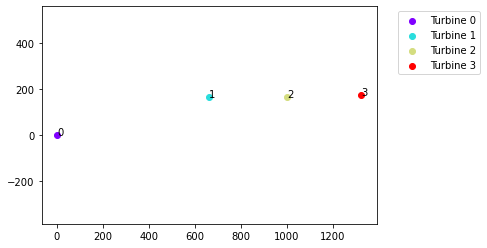

Best solution: [[   0.            0.        ]
 [ 660.20929559  166.08307548]
 [ 999.68269048  164.25800406]
 [1323.15500511  173.21673579]]
 
Optimised Power Output:  39.4523212002165
Optimised Uncertainty:  [[0.00669342]
 [0.00669342]
 [0.25305178]
 [1.37515895]]
Optimised Total Uncertainty:  1.6415975723219607
Optimised Wind Speed:  [[7.39772673]
 [7.39772673]
 [4.87991199]
 [4.9815023 ]]

2.

[[1.         1.         1.        ]
 [1.         1.         1.        ]
 [0.66275293 0.19115751 0.12342062]
 [0.32820948 0.67560958 1.        ]]
 
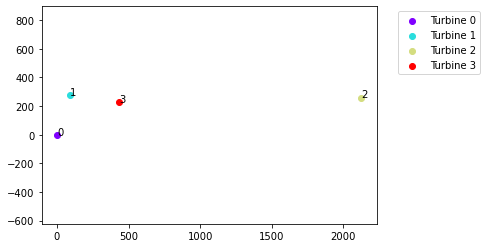
Best solution: [[   0.            0.        ]
 [  91.51035199  273.43803438]
 [2124.50237075  258.32534533]
 [ 431.95665125  227.74876144]]
 
Optimised Power Output:  45.94805262742876
Optimised Uncertainty:  [[0.00676645]
 [0.00676645]
 [1.55401096]
 [0.00716571]]
Optimised Total Uncertainty:  1.5747095682006043
Optimised Wind Speed:  [[7.39794871]
 [7.39794871]
 [4.57515955]
 [5.89054911]]

Train similar fingerprints set:

[[1.         1.         1.        ]
 [1.         1.         1.        ]
 [0.36316264 0.67464852 1.        ]
 [0.17842871 0.58430469 0.06826306]]

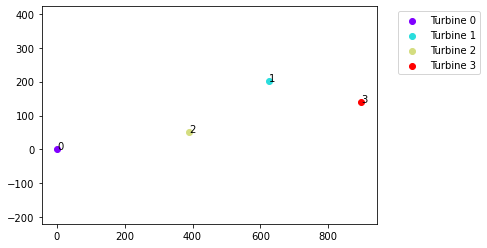

[[  0.           0.        ]
 [625.26204523 202.54367876]
 [390.38093941  51.95458178]
 [897.30078212 140.60882887]]

Optimised Power Output:  53.31118467125076
Optimised Uncertainty:  [[0.00688552]
 [0.00688552]
 [0.00713016]
 [0.36860636]]
Optimised Total Uncertainty:  0.3895075682799913
Optimised Wind Speed:  [[7.39715333]
 [7.39715333]
 [6.12922668]
 [5.732059  ]]

 
Test set:

[[1.         1.         1.        ]
 [1.         1.         1.        ]
 [0.63920869 0.32976494 0.09896368]
 [0.2880004  0.24133581 1.        ]]
 
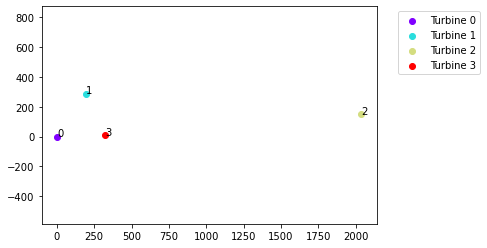
[[   0.            0.        ]
 [ 194.04045497  287.87936105]
 [2036.38375936  148.47537671]
 [ 320.33352912   10.34616954]]
Optimised Power Output:  45.82525430043173
Optimised Uncertainty:  [[0.00659174]
 [0.00659174]
 [1.91422383]
 [0.00714709]]
Optimised Total Uncertainty:  1.9345544124519163
Optimised Wind Speed:  [[7.39822176]
 [7.39822176]
 [5.64996759]
 [4.93243207]]
 
 after 1. train 4 turbine data:
 Optimised Power Output:  45.671688453429184
Optimised Uncertainty:  [[0.00674231]
 [0.00674231]
 [1.83943951]
 [0.00729931]]
Optimised Total Uncertainty:  1.8602234395089574
Optimised Wind Speed:  [[7.39764365]
 [7.39764365]
 [5.57528227]
 [4.93054931]]
 
after 2. train 4 turbine data:
Optimised Power Output:  48.07408052492184
Optimised Uncertainty:  [[0.00688552]
 [0.00688552]
 [0.04773983]
 [0.00744494]]
Optimised Total Uncertainty:  0.06895581513658225
Optimised Wind Speed:  [[7.39715333]
 [7.39715333]
 [6.76145115]
 [4.96256492]]

after similar turbine fingerprints:

Optimised Power Output:  47.339905475909845
Optimised Uncertainty:  [[0.00691028]
 [0.00691028]
 [0.14560726]
 [0.00748588]]
Optimised Total Uncertainty:  0.1669137103374134
Optimised Wind Speed:  [[7.39728083]
 [7.39728083]
 [6.39196766]
 [4.96684685]]


 after 1 set 3 turbine data with maximal uncertainty of 0.8:
 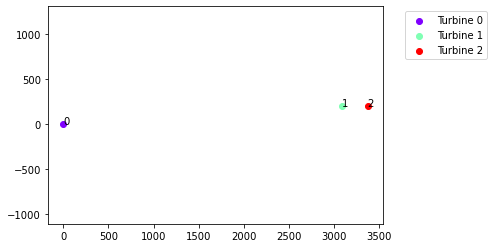
 
Optimised Power Output:  46.07962717728793
Optimised Uncertainty:  [[0.00676645]
 [0.00676645]
 [1.78413679]
 [0.00732404]]
Optimised Total Uncertainty:  1.8049937217428544
Optimised Wind Speed:  [[7.39794871]
 [7.39794871]
 [5.77915531]
 [4.92952172]]


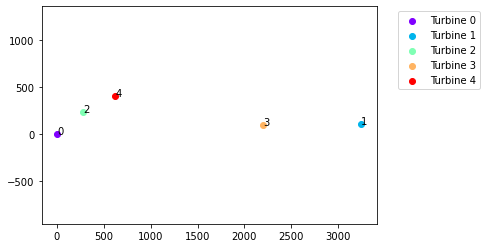

In [74]:
numturb = locga.shape[0]

cmap = plt.get_cmap('rainbow', numturb)

for i in range(numturb):
    plt.scatter(locga[i,0], locga[i,1], color=cmap(i), label='Turbine ' + str(i))

# Set the desired limits for the x and yaxes
plt.xlim(-300, 4500)
plt.ylim(-500, 500)
plt.axis('equal')

# Add labels to each point
for i in range(numturb):
    plt.text(locga[i, 0], locga[i, 1], str(i))

# Add legends
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [53]:
fixed_turbine_positions = [
    (0, 0),
    (194.04045497, 287.87936105)
]


In [54]:
symbol = "Siemens"
turb = [symbol] * 3  
nl = exponential_new.NeighborlistCalculator(cutoff=4001, cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
finpr = exponential_new.FingerprintCalculator(
    cutoff=4001, 
    Gs=Gs,
    Rct=3000,
    delta_R=100,
    cone_grad=0.12582561117875557,
    cone_offset=72.24947126849844
)

In [55]:
num_candidates = 10000
candidate_positions = np.zeros((num_candidates, 2))
np.random.seed(42)

for i in range(num_candidates):
    while True:
        candidate = np.array([
            np.random.uniform(-300, 4500),
            np.random.uniform(-500, 500)
        ])
        distances = [np.linalg.norm(candidate - np.array(pos)) for pos in fixed_turbine_positions]
        if all(dist > min_dist for dist in distances):
            candidate_positions[i] = candidate
            break


In [75]:
[Ypred,Yvar]=m_ga.predict(Xtest)
error_test=np.abs(Ypred-Ytest)
np.max(error_test)

0.3908079975362835

In [76]:
[Yval,Yvalvar]=m_ga.predict(Xtrain)
error_train=np.abs(Yval-Ytrain)
np.max(error_train)

0.44716532468607717

In [77]:
[Yall,Yallvar]=m_ga.predict(X)
error_all=np.abs(Yall-Y)
np.max(error_all)

0.44716532468607717

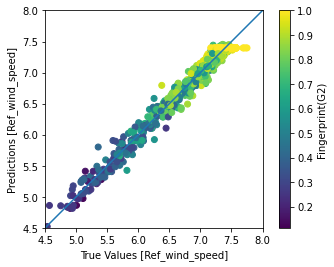

In [78]:
a = plt.axes(aspect='equal')
plt.scatter(Ytest, Ypred,c=Xtest[:,0])     #"Fingerprint(G2)"
plt.scatter(Ytrain, Yval,c=Xtrain[:,0])  #"Fingerprint(G2)"
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
cbar=plt.colorbar()
cbar.set_label('Fingerprint(G2)')
lims = [4.5, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

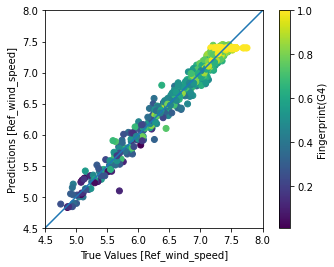

In [100]:
a = plt.axes(aspect='equal')
plt.scatter(Ytest, Ypred,c=Xtest[:,1])     #"Fingerprint(G4)"
plt.scatter(Ytrain, Yval,c=Xtrain[:,1])  #"Fingerprint(G4)"
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
cbar=plt.colorbar()
cbar.set_label('Fingerprint(G4)')
lims = [4.5, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

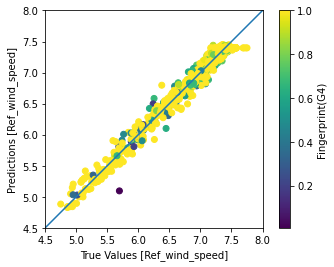

In [101]:
a = plt.axes(aspect='equal')
plt.scatter(Ytest, Ypred,c=Xtest[:,2])     #"Fingerprint(G6)"
plt.scatter(Ytrain, Yval,c=Xtrain[:,2])  #"Fingerprint(G6)"
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
cbar=plt.colorbar()
cbar.set_label('Fingerprint(G4)')
lims = [4.5, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

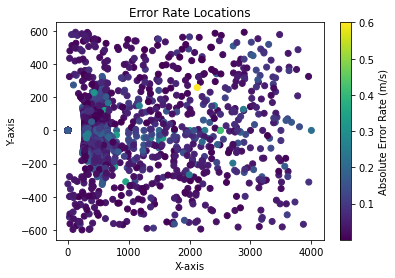

In [102]:
plt.scatter(dataset_pos[:,0], dataset_pos[:,1],c=error_all) # Result gives worse with added data
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Error Rate Locations')
cbar=plt.colorbar()
cbar.set_label('Absolute Error Rate (m/s)')

all_dataset
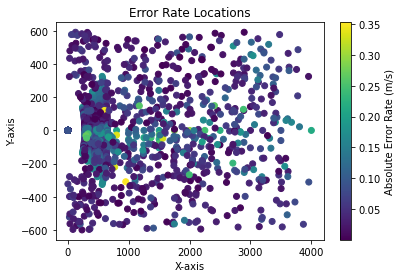

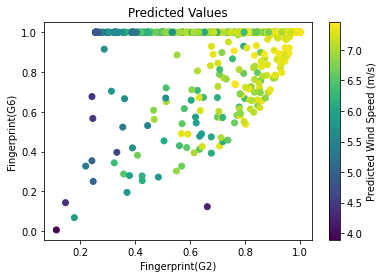

In [103]:
a = plt.axes
plt.scatter(Xtest[:,0], Xtest[:,2],c=np.abs(Ypred))
plt.scatter(Xtrain[:,0], Xtrain[:,2],c=np.abs(Yval))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G6)')
plt.title('Predicted Values')
cbar=plt.colorbar()
cbar.set_label('Predicted Wind Speed (m/s)')

all_dataset
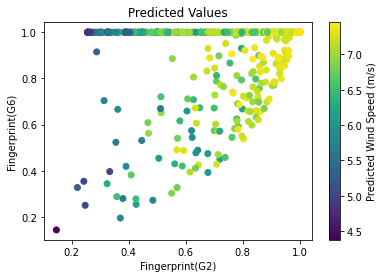

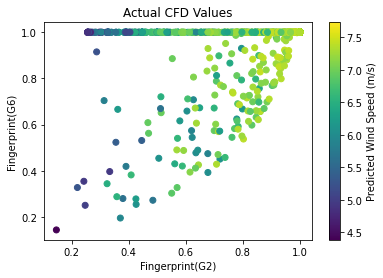

In [86]:
a = plt.axes
plt.scatter(Xtest[:,0], Xtest[:,2],c=np.abs(Ytest))
plt.scatter(Xtrain[:,0], Xtrain[:,2],c=np.abs(Ytrain))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G6)')
plt.title('Actual CFD Values')
cbar=plt.colorbar()
cbar.set_label('Predicted Wind Speed (m/s)')

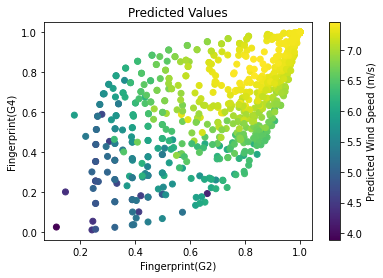

In [104]:
a = plt.axes
plt.scatter(Xtest[:,0], Xtest[:,1],c=np.abs(Ypred))
plt.scatter(Xtrain[:,0], Xtrain[:,1],c=np.abs(Yval))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G4)')
plt.title('Predicted Values')
cbar=plt.colorbar()
cbar.set_label('Predicted Wind Speed (m/s)')

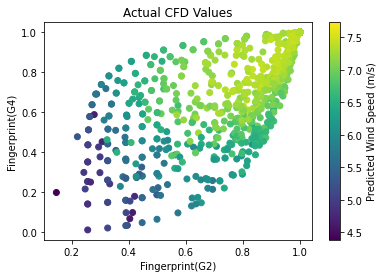

In [88]:
a = plt.axes
plt.scatter(Xtest[:,0], Xtest[:,1],c=np.abs(Ytest))
plt.scatter(Xtrain[:,0], Xtrain[:,1],c=np.abs(Ytrain))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G4)')
plt.title('Actual CFD Values')
cbar=plt.colorbar()
cbar.set_label('Predicted Wind Speed (m/s)')

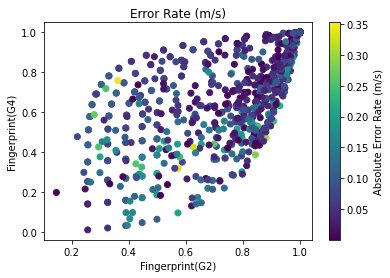

In [89]:
a = plt.axes
plt.scatter(X[:,0], X[:,1],c=error_all)
#plt.scatter(Xtrain[:,0], Xtrain[:,1],c=np.abs(Ytrain))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G4)')
plt.title('Error Rate (m/s)')
cbar=plt.colorbar()
cbar.set_label('Absolute Error Rate (m/s)')

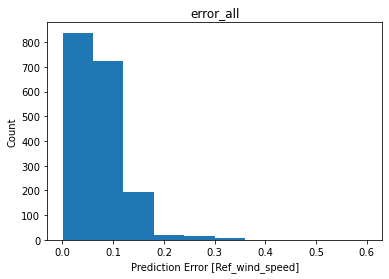

In [105]:
plt.hist(error_all, bins=10)
plt.xlabel('Prediction Error [Ref_wind_speed]') # Really different error rates, one more spread, one more concentrate
plt.title('error_all')
_ = plt.ylabel('Count')

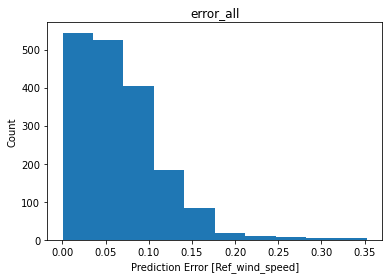

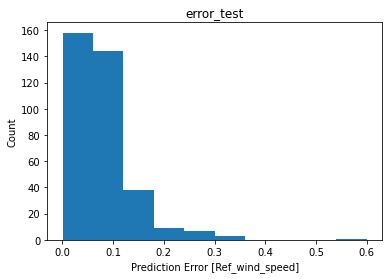

In [106]:
plt.hist(error_test, bins=10)
plt.xlabel('Prediction Error [Ref_wind_speed]')
plt.title('error_test')
_ = plt.ylabel('Count')

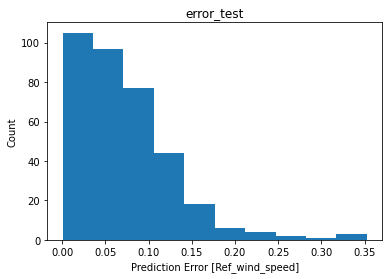

In [56]:
uncertainties = np.zeros(num_candidates)

for idx, point in enumerate(candidate_positions):
    turbines = np.array(fixed_turbine_positions + [tuple(point)])
    neigh = nl.calculate(turb, turbines)
    fingerprints = np.array(finpr.calculate(turb, turbines, neigh, symbol))
    refwind, refstdev = m.predict(fingerprints)
    
    uncertainties[idx] = refstdev[2]  # Uncertainty for the fourth turbine

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


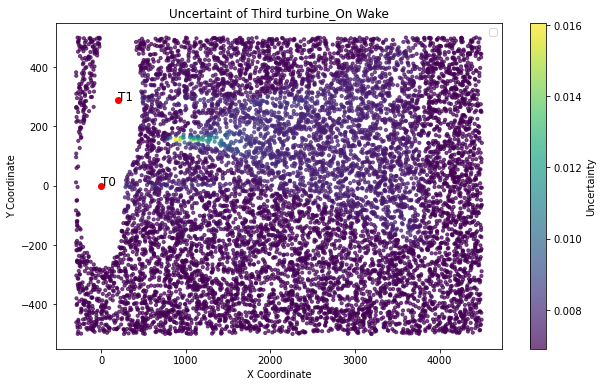

In [60]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(candidate_positions[:, 0], candidate_positions[:, 1], c=uncertainties, cmap='viridis', s=10, alpha=0.7)
plt.colorbar(sc, label='Uncertainty')

# Plot fixed turbine positions
for i, (x, y) in enumerate(fixed_turbine_positions):
    plt.scatter(x, y, color='red')

# Labeling fixed turbines
for i, (x, y) in enumerate(fixed_turbine_positions):
    plt.text(x, y, f'T{i}', fontsize=12)

plt.title('Uncertaint of Third turbine_On Wake')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.show()

In [58]:
uncertainties = np.zeros(num_candidates)

for idx, point in enumerate(candidate_positions):
    turbines = np.array(fixed_turbine_positions + [tuple(point)])
    neigh = nl.calculate(turb, turbines)
    fingerprints = np.array(finpr.calculate(turb, turbines, neigh, symbol))
    refwind, refstdev = m_ga.predict(fingerprints)
    uncertainties[idx] = refstdev[2]  # Uncertainty for the fourth turbine


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


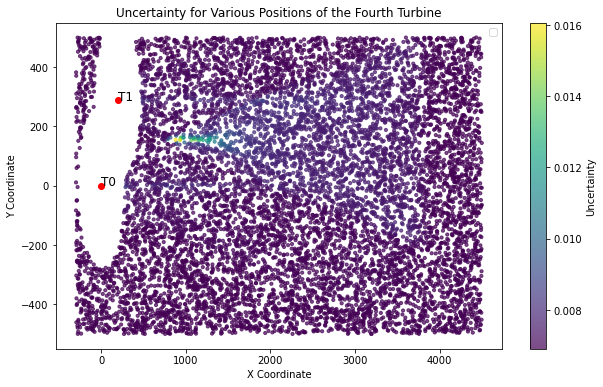

In [59]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(candidate_positions[:, 0], candidate_positions[:, 1], c=uncertainties, cmap='viridis', s=10, alpha=0.7)
plt.colorbar(sc, label='Uncertainty')

# Plot fixed turbine positions
for i, (x, y) in enumerate(fixed_turbine_positions):
    plt.scatter(x, y, color='red')

# Labeling fixed turbines
for i, (x, y) in enumerate(fixed_turbine_positions):
    plt.text(x, y, f'T{i}', fontsize=12)

plt.title('Uncertaint of Third turbine_On Wake')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.show()

pick the one active learning strategy worked on

## Particle Swarm Optimisation (PSO)

Particle Swarm Optimisation (PSO) is a population-based stochastic optimisation method. In PSO, each particle represents a potential solution and adjusts its position based on its own experience and the experience of neighbouring particles.

1. **Initialisation:**
   - Initialise a swarm of `n` particles with random positions and velocities.
   - Define the objective function $ f(x) $ to be minimised.

2. **Velocity and Position Update:**
   - Update the velocity $ v_i(t+1) $ and position $ x_i(t+1) $ of each particle $ i $ using the equations:
     $[
     v_i(t+1) = w \cdot v_i(t) + c_1 \cdot r_1 \cdot (p_i - x_i(t)) + c_2 \cdot r_2 \cdot (g - x_i(t))
     ]$
     $[
     x_i(t+1) = x_i(t) + v_i(t+1)
     ]$
     
     where:
     - $ w $ is the inertia weight.
     - $ c_1 $ and $ c_2 $ are cognitive and social coefficients.
     - $ r_1 $ and $ r_2 $ are random numbers in the range [0, 1].
     - $ p_i $ is the personal best position of particle $ i $.
     - $ g $ is the global best position of the swarm.

3. **Personal Best and Global Best Update:**
   - Update the personal best position $ p_i $ if the current position $ x_i(t+1) $ yields a better value.
   - Update the global best position $ g $ if any personal best position yields a better value.

4. **Termination:**
   - Repeat the velocity and position update steps until a stopping criterion is met (e.g., a maximum number of iterations or a satisfactory std threshold).


In [129]:
dataset_full = pd.read_csv('all_dataset.csv',index_col=0)
symbol="Siemens"
k=0
count=0
dataset_full["IDnum"]=pd.Series()
for i in range(len(dataset_full)):
    dataset_full.at[i,"IDnum"]=k
    count = count +1
    if (count==dataset_full["Num_tot_turb"].iloc[i]):
        k=k+1
        count=0
dataset_full["Num_tot_turb"]=dataset_full["Num_tot_turb"].astype(int)
dataset_full["Turb_num"]=dataset_full["Turb_num"].astype(int)
dataset_full["IDnum"]=dataset_full["IDnum"].astype(int)
numsims=dataset_full["IDnum"].iloc[-1]+1
turb = [symbol]


 /tmp/ipykernel_3791245/3419946711.py:5: FutureWarning:The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [130]:
nl=exponential_new.NeighborlistCalculator(cutoff=4001,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
Gs = {"Siemens": [{"type":"G2", "turbine":"Siemens","eta":4.25387599, "offset": 1.0151402},
                  {"type":"G4", "elements":"Siemens","eta":2.56450515, "gamma":8.04475192, "zeta": 2.5356155},
                  {"type":"G6", "elements":"Siemens","eta":2.33043463, "gamma": 0.50753377, "zeta": 0.93372721},
                  
                 ]}
finpr=exponential_new.FingerprintCalculator(cutoff=4001,Gs=Gs,Rct=3000,delta_R=100,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
count=0
dataset_fp=np.empty(shape=(0, 3))
dataset_ws=np.empty(shape=(0, 1))
dataset_pos=np.empty(shape=(0, 2))
for i in range(numsims):
    numturb=dataset_full["Num_tot_turb"].iloc[count]
    position = np.empty((numturb,2))
    ws = np.empty((numturb,1))
    fp = np.empty((numturb,3))
    for k in range(numturb):
        position[k,0]=dataset_full.at[count,"X_coord"]
        position[k,1]=dataset_full.at[count,"Y_coord"]
        ws[k,0]=dataset_full.at[count,"Ref_wind"]
        count = count+ 1
    neigh=nl.calculate(turb*numturb,position)
    fingerprints=finpr.calculate(turb*numturb,position,neigh,symbol)
    fingerprints=np.array(fingerprints)
    dataset_fp=np.append(dataset_fp,fingerprints,axis=0)
    dataset_ws=np.append(dataset_ws,ws,axis=0)
    dataset_pos=np.append(dataset_pos,position,axis=0)
dataset=np.concatenate((dataset_fp, dataset_ws),axis=1)
dataset = pd.DataFrame(dataset, columns = ['Fingerprint(G2)','Fingerprint(G4)','Fingerprint(G6)','Ref_Wind_Speed'])
X=dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Y=dataset[["Ref_Wind_Speed"]].to_numpy()
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
Xtrain=train_dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Ytrain=train_dataset[["Ref_Wind_Speed"]].to_numpy()
Xtest=test_dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Ytest=test_dataset[["Ref_Wind_Speed"]].to_numpy()

In [131]:
ker = GPy.kern.RBF(3,lengthscale=0.1)# + GPy.kern.White(2)

In [132]:
# m = GPy.models.SparseGPRegression(Xtrain,Ytrain,ker)
m_pso = GPy.models.GPRegression(Xtrain,Ytrain,ker)

In [133]:
m_pso.optimize(messages=True,max_f_eval = 1000)


In [134]:
pop_size=30
max_iter=100
inertia=0.5
cognitive=1.5
social=1.5

In [135]:
numturb=5

In [136]:
def fitness_function(turbines, min_dist):
    numturb = turbines.shape[0]
    distances = pairwise_distances(turbines)
    np.fill_diagonal(distances, np.inf)  # Ignore self-distances
    
    if np.any(distances < min_dist):
        return -np.inf  # Penalize solutions with close turbines
    
    neigh = nl.calculate(['Siemens'] * numturb, turbines)
    fingerprints = np.array(finpr.calculate(['Siemens'] * numturb, turbines, neigh, 'Siemens'))
    _, refstdev = m_pso.predict(fingerprints)
    total_uncertainty = np.sum(refstdev)
    return total_uncertainty

# Initialize particles and velocities
def initialize_particles(pop_size, num_turb, bounds):
    particles = np.random.uniform(bounds[0], bounds[1], (pop_size, num_turb, 2))
    particles[:, 0, :] = [0, 0]  # Fix the first turbine at (0, 0)
    velocities = np.random.uniform(-1, 1, (pop_size, num_turb, 2))
    return particles, velocities

# Update velocity of a particle
def update_velocity(particle, velocity, personal_best, global_best, inertia, cognitive, social):
    r1, r2 = np.random.rand(), np.random.rand()
    new_velocity = (
        inertia * velocity +
        cognitive * r1 * (personal_best - particle) +
        social * r2 * (global_best - particle)
    )
    return new_velocity

# Update position of a particle
def update_position(particle, velocity, bounds):
    new_position = particle + velocity
    new_position = np.clip(new_position, bounds[0], bounds[1])
    new_position[0] = [0, 0]  # Ensure the first turbine stays fixed at (0, 0)
    return new_position

# Particle Swarm Optimisation (PSO) algorithm
def pso(bounds, min_dist, num_turb, pop_size, max_iter, inertia, cognitive, social):
    particles, velocities = initialize_particles(pop_size, num_turb, bounds)
    personal_bests = particles.copy()
    personal_best_fitnesses = np.array([fitness_function(p, min_dist) for p in particles])
    global_best = particles[np.argmax(personal_best_fitnesses)]
    global_best_fitness = np.max(personal_best_fitnesses)
    
    for iteration in range(max_iter):
        for i in range(pop_size):
            fitness = fitness_function(particles[i], min_dist)
            if fitness > personal_best_fitnesses[i]:
                personal_bests[i] = particles[i]
                personal_best_fitnesses[i] = fitness
                
                if fitness > global_best_fitness:
                    global_best = particles[i]
                    global_best_fitness = fitness
        
        for i in range(pop_size):
            velocities[i] = update_velocity(particles[i], velocities[i], personal_bests[i], global_best, inertia, cognitive, social)
            particles[i] = update_position(particles[i], velocities[i], bounds)
        
        print(f"Iteration {iteration}: Max Uncertainty = {global_best_fitness}")
    
    return global_best

In [147]:
locpso = pso(bounds, min_dist, 5, pop_size, max_iter, inertia, cognitive, social)

print("Optimised Turbine Locations:", locpso)

Iteration 0: Max Uncertainty = 0.18720492464241073
Iteration 1: Max Uncertainty = 0.3487195956613457
Iteration 2: Max Uncertainty = 0.3487195956613457
Iteration 3: Max Uncertainty = 0.3487195956613457
Iteration 4: Max Uncertainty = 0.3487195956613457
Iteration 5: Max Uncertainty = 0.3487195956613457
Iteration 6: Max Uncertainty = 0.3833766677138174
Iteration 7: Max Uncertainty = 0.3833766677138174
Iteration 8: Max Uncertainty = 0.383388704173831
Iteration 9: Max Uncertainty = 0.552830354588855
Iteration 10: Max Uncertainty = 0.6286697625329
Iteration 11: Max Uncertainty = 0.6286697625329
Iteration 12: Max Uncertainty = 0.6836652693800028
Iteration 13: Max Uncertainty = 0.6836652693800028
Iteration 14: Max Uncertainty = 0.6855010405098009
Iteration 15: Max Uncertainty = 0.6855010405098009
Iteration 16: Max Uncertainty = 0.6855010405098009
Iteration 17: Max Uncertainty = 0.6855010405098009
Iteration 18: Max Uncertainty = 0.6855010405098009
Iteration 19: Max Uncertainty = 0.68859297852135

In [148]:
print(locpso)

[[   0.            0.        ]
 [1512.717558    372.04693565]
 [1791.72983491  372.04407344]
 [1228.64251796  372.94359962]
 [2949.61746522  372.07301232]]


In [149]:
neighpso=nl.calculate(turb*5,locpso)
fingerprints=np.array(finpr.calculate(turb*5,locpso,neighpso,symbol))
print(fingerprints)
refwindpso,refstdevpso=m_pso.predict(fingerprints)

[[1.00000000e+00 1.00000000e+00 1.00000000e+00]
 [2.59886477e-01 3.75958547e-02 1.00000000e+00]
 [1.15117165e-01 7.69270892e-04 4.58783986e-02]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00]
 [4.45750852e-01 1.89418139e-02 1.33230624e-02]]


In [150]:
print('Optimised Power Output: ', calculate_power_output(refwindpso, min_threshold, max_threshold))
print('Optimised Uncertainty: ', refstdevpso)
print('Optimised Total Uncertainty: ', np.sum(refstdevpso))
print('Optimised Wind Speed: ', refwindpso)

Optimised Power Output:  42.49775689324075
Optimised Uncertainty:  [[0.00666389]
 [0.00906462]
 [0.3259121 ]
 [0.00666389]
 [0.38769377]]
Optimised Total Uncertainty:  0.7359982743965349
Optimised Wind Speed:  [[7.39826054]
 [4.86042958]
 [3.82564166]
 [7.39826054]
 [4.2186435 ]]


Train set:

[[1.         1.         1.        ]
 [0.25588112 0.01239282 1.        ]
 [0.33952957 0.01079583 0.13048027]
 [0.42178683 0.01586078 0.04671849]]


Optimised Turbine Locations: 
[[   0.            0.        ]
 [ 279.00007796    0.        ]
 [ 979.99939153    0.        ]
 [1851.90702543    0.        ]]
 
Optimised Power Output:  29.152516037780927
Optimised Uncertainty:  [[0.00688552]
 [0.01031539]
 [0.07393817]
 [0.11235459]]
Optimised Total Uncertainty:  0.20349366874677266
Optimised Wind Speed:  [[7.39715333]
 [4.83040044]
 [4.72665188]
 [4.80115706]]



Test/
Optimised Turbine Locations: 

[[   0.            0.        ]
 [ 277.75285262   27.30398144]
 [ 115.22636492  254.10623383]
 [2071.68149552  232.73516173]]
 


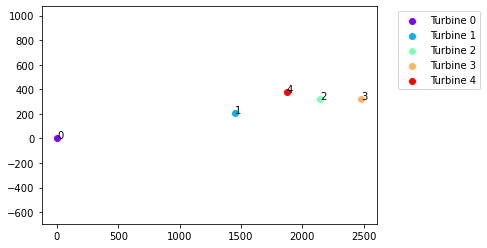

In [146]:
numturb = locpso.shape[0]

cmap = plt.get_cmap('rainbow', numturb)

for i in range(numturb):
    plt.scatter(locpso[i,0], locpso[i,1], color=cmap(i), label='Turbine ' + str(i))

# Set the desired limits for the x and yaxes
plt.xlim(-300, 4500)
plt.ylim(-500, 500)
plt.axis('equal')

# Add labels to each point
for i in range(numturb):
    plt.text(locpso[i, 0], locpso[i, 1], str(i))

# Add legends
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


## PSO-GA

Essentally based on previous methods to have more optimal and escape local macxima

In [47]:
pop_size = 30
max_iter = 100
num_generations = 50
inertia = 0.5
cognitive = 1.5
social = 1.5

In [48]:
def hybrid_pso_ga(bounds, min_dist, num_turb, pop_size, max_iter, num_generations, inertia, cognitive, social):
    # Step1: PSO Optimisation
    print("Starting PSO Optimisation...")
    pso_best_solution = pso(bounds, min_dist, num_turb, pop_size, max_iter, inertia, cognitive, social)
    
    # Step2: Initialise GA population with PSO best solution
    print("Starting GA Optimization...")
    initial_population = generate_population(pop_size, num_turb, bounds)
    initial_population[0] = pso_best_solution  # Seed the GA with PSO's best solution
    
    best_solution = genetic_algorithm(bounds, min_dist, num_turb, pop_size, num_generations)
    
    return best_solution



# Run the hybrid PSO-GA optimization
hpg_solution = hybrid_pso_ga(bounds, min_dist, numturb, pop_size, max_iter, num_generations, inertia, cognitive, social)

print("Optimized Turbine Locations:", hpg_solution)


Starting PSO Optimisation...
Iteration 0: Max Uncertainty = 0.08968965083828778
Iteration 1: Max Uncertainty = 0.18896606968041116
Iteration 2: Max Uncertainty = 0.218670393732143
Iteration 3: Max Uncertainty = 0.218670393732143
Iteration 4: Max Uncertainty = 0.32844254834407816
Iteration 5: Max Uncertainty = 1.0540701266666586
Iteration 6: Max Uncertainty = 1.0540701266666586
Iteration 7: Max Uncertainty = 1.0540701266666586
Iteration 8: Max Uncertainty = 1.0540701266666586
Iteration 9: Max Uncertainty = 1.0540701266666586
Iteration 10: Max Uncertainty = 1.0540701266666586
Iteration 11: Max Uncertainty = 1.0540701266666586
Iteration 12: Max Uncertainty = 1.0540701266666586
Iteration 13: Max Uncertainty = 1.0574968517637906
Iteration 14: Max Uncertainty = 1.0574968517637906
Iteration 15: Max Uncertainty = 1.0574968517637906
Iteration 16: Max Uncertainty = 1.0948336426246783
Iteration 17: Max Uncertainty = 1.1593691883580737
Iteration 18: Max Uncertainty = 1.1593691883580737
Iteration 1

In [49]:
neighhpg=nl.calculate(turb*numturb,hpg_solution)
fingerprints=np.array(finpr.calculate(turb*numturb,hpg_solution,neighhpg,symbol))
refwindhpg,refstdevhpg=m.predict(fingerprints)

In [50]:
print('Optimised Power Output: ', calculate_power_output(refwindhpg, min_threshold, max_threshold))
print('Optimised Uncertainty: ', refstdevhpg)
print('Optimised Total Uncertainty: ', np.sum(refstdevhpg))
print('Optimised Wind Speed: ', refwindhpg)

Optimised Power Output:  33.83940119724774
Optimised Uncertainty:  [[0.00659174]
 [0.00670596]
 [0.75020538]]
Optimised Total Uncertainty:  0.7635030872821492
Optimised Wind Speed:  [[7.39822176]
 [7.32639879]
 [4.3901601 ]]


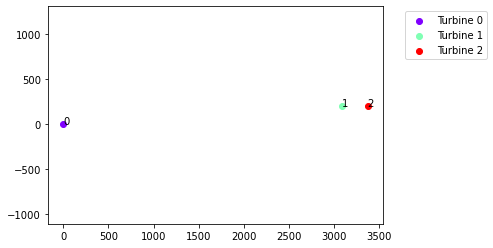

In [51]:
numturb = hpg_solution.shape[0]

cmap = plt.get_cmap('rainbow', numturb)

for i in range(numturb):
    plt.scatter(hpg_solution[i,0], hpg_solution[i,1], color=cmap(i), label='Turbine ' + str(i))

# Set the desired limits for the x and yaxes
plt.xlim(-300, 4500)
plt.ylim(-500, 500)
plt.axis('equal')

# Add labels to each point
for i in range(numturb):
    plt.text(hpg_solution[i, 0], hpg_solution[i, 1], str(i))

# Add legends
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


## Simulated Annealing

In [151]:
dataset_full = pd.read_csv('all_dataset.csv',index_col=0)
symbol="Siemens"
k=0
count=0
dataset_full["IDnum"]=pd.Series()
for i in range(len(dataset_full)):
    dataset_full.at[i,"IDnum"]=k
    count = count +1
    if (count==dataset_full["Num_tot_turb"].iloc[i]):
        k=k+1
        count=0
dataset_full["Num_tot_turb"]=dataset_full["Num_tot_turb"].astype(int)
dataset_full["Turb_num"]=dataset_full["Turb_num"].astype(int)
dataset_full["IDnum"]=dataset_full["IDnum"].astype(int)
numsims=dataset_full["IDnum"].iloc[-1]+1
turb = [symbol]


 /tmp/ipykernel_3791245/3419946711.py:5: FutureWarning:The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [152]:
nl=exponential_new.NeighborlistCalculator(cutoff=4001,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
Gs = {"Siemens": [{"type":"G2", "turbine":"Siemens","eta":4.25387599, "offset": 1.0151402},
                  {"type":"G4", "elements":"Siemens","eta":2.56450515, "gamma":8.04475192, "zeta": 2.5356155},
                  {"type":"G6", "elements":"Siemens","eta":2.33043463, "gamma": 0.50753377, "zeta": 0.93372721},
                  
                 ]}
finpr=exponential_new.FingerprintCalculator(cutoff=4001,Gs=Gs,Rct=3000,delta_R=100,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
count=0
dataset_fp=np.empty(shape=(0, 3))
dataset_ws=np.empty(shape=(0, 1))
dataset_pos=np.empty(shape=(0, 2))
for i in range(numsims):
    numturb=dataset_full["Num_tot_turb"].iloc[count]
    position = np.empty((numturb,2))
    ws = np.empty((numturb,1))
    fp = np.empty((numturb,3))
    for k in range(numturb):
        position[k,0]=dataset_full.at[count,"X_coord"]
        position[k,1]=dataset_full.at[count,"Y_coord"]
        ws[k,0]=dataset_full.at[count,"Ref_wind"]
        count = count+ 1
    neigh=nl.calculate(turb*numturb,position)
    fingerprints=finpr.calculate(turb*numturb,position,neigh,symbol)
    fingerprints=np.array(fingerprints)
    dataset_fp=np.append(dataset_fp,fingerprints,axis=0)
    dataset_ws=np.append(dataset_ws,ws,axis=0)
    dataset_pos=np.append(dataset_pos,position,axis=0)
dataset=np.concatenate((dataset_fp, dataset_ws),axis=1)
dataset = pd.DataFrame(dataset, columns = ['Fingerprint(G2)','Fingerprint(G4)','Fingerprint(G6)','Ref_Wind_Speed'])
X=dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Y=dataset[["Ref_Wind_Speed"]].to_numpy()
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
Xtrain=train_dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Ytrain=train_dataset[["Ref_Wind_Speed"]].to_numpy()
Xtest=test_dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Ytest=test_dataset[["Ref_Wind_Speed"]].to_numpy()

In [153]:
ker = GPy.kern.RBF(3,lengthscale=0.1)# + GPy.kern.White(2)

In [154]:
# m = GPy.models.SparseGPRegression(Xtrain,Ytrain,ker)
m_sa = GPy.models.GPRegression(Xtrain,Ytrain,ker)

In [155]:
m_sa.optimize(messages=True,max_f_eval = 1000)


In [156]:
initial_temp = 100
cooling_rate = 0.99
max_iter = 1000

In [157]:
def fitness_function(turbines, min_dist):
    numturb = turbines.shape[0]
    distances = pairwise_distances(turbines)
    np.fill_diagonal(distances, np.inf)  # Ignore self-distances
    
    if np.any(distances < min_dist):
        return -np.inf  # Penalize solutions with close turbines
    
    neigh = nl.calculate(['Siemens'] * numturb, turbines)
    fingerprints = np.array(finpr.calculate(['Siemens'] * numturb, turbines, neigh, 'Siemens'))
    _, refstdev = m_sa.predict(fingerprints)
    total_uncertainty = np.sum(refstdev)
    return total_uncertainty

def mutate(individual, bounds):
    num_turb = individual.shape[0]
    for i in range(num_turb):
        if np.random.rand() < 0.5:  # Randomly choose to mutate each turbine location
            individual[i, 0] = np.random.uniform(bounds[0][0], bounds[1][0])
            individual[i, 1] = np.random.uniform(bounds[0][1], bounds[1][1])
    return individual

def simulated_annealing(bounds, min_dist, num_turb, initial_temp, cooling_rate, max_iter):
    current_solution = np.random.uniform(bounds[0], bounds[1], (num_turb, 2))
    current_solution[0] = [0, 0]  # Fix the first turbine at (0, 0)
    current_fitness = fitness_function(current_solution, min_dist)
    best_solution = current_solution.copy()
    best_fitness = current_fitness
    temperature = initial_temp
    
    for iteration in range(max_iter):
        new_solution = mutate(current_solution.copy(), bounds)
        new_solution[0] = [0, 0]  # Fix the first turbine at (0, 0)
        new_fitness = fitness_function(new_solution, min_dist)
        
        if new_fitness > current_fitness:
            current_solution = new_solution
            current_fitness = new_fitness
        else:
            acceptance_probability = np.exp((new_fitness - current_fitness) / temperature)
            if np.random.rand() < acceptance_probability:
                current_solution = new_solution
                current_fitness = new_fitness
        
        if current_fitness > best_fitness:
            best_solution = current_solution
            best_fitness = current_fitness
        
        temperature *= cooling_rate
        
        if temperature < 1e-10:  # Stopping criterion based on temperature
            break
        
        print(f"Iteration {iteration}: Max uncertainties = {best_fitness}")
    
    return best_solution

In [170]:
locsa = simulated_annealing(bounds, min_dist, num_turb=5, initial_temp=initial_temp, cooling_rate=cooling_rate, max_iter=max_iter)

Iteration 0: Max uncertainties = 0.035216526392675966
Iteration 1: Max uncertainties = 0.035216526392675966
Iteration 2: Max uncertainties = 0.03761718255900231
Iteration 3: Max uncertainties = 0.03761718255900231
Iteration 4: Max uncertainties = 0.03938875080386122
Iteration 5: Max uncertainties = 0.039664901841226445
Iteration 6: Max uncertainties = 0.10187799651415005
Iteration 7: Max uncertainties = 0.10187799651415005
Iteration 8: Max uncertainties = 0.10187799651415005
Iteration 9: Max uncertainties = 0.10187799651415005
Iteration 10: Max uncertainties = 0.10187799651415005
Iteration 11: Max uncertainties = 0.10187799651415005
Iteration 12: Max uncertainties = 0.10187799651415005
Iteration 13: Max uncertainties = 0.10187799651415005
Iteration 14: Max uncertainties = 0.10187799651415005
Iteration 15: Max uncertainties = 0.10187799651415005
Iteration 16: Max uncertainties = 0.10187799651415005
Iteration 17: Max uncertainties = 0.10187799651415005
Iteration 18: Max uncertainties = 0

Iteration 170: Max uncertainties = 0.3235247001695095
Iteration 171: Max uncertainties = 0.3235247001695095
Iteration 172: Max uncertainties = 0.3235247001695095
Iteration 173: Max uncertainties = 0.3235247001695095
Iteration 174: Max uncertainties = 0.3235247001695095
Iteration 175: Max uncertainties = 0.3235247001695095
Iteration 176: Max uncertainties = 0.3235247001695095
Iteration 177: Max uncertainties = 0.3235247001695095
Iteration 178: Max uncertainties = 0.3235247001695095
Iteration 179: Max uncertainties = 0.3235247001695095
Iteration 180: Max uncertainties = 0.3235247001695095
Iteration 181: Max uncertainties = 0.3235247001695095
Iteration 182: Max uncertainties = 0.3235247001695095
Iteration 183: Max uncertainties = 0.3235247001695095
Iteration 184: Max uncertainties = 0.3235247001695095
Iteration 185: Max uncertainties = 0.3235247001695095
Iteration 186: Max uncertainties = 0.3235247001695095
Iteration 187: Max uncertainties = 0.3235247001695095
Iteration 188: Max uncertain

Iteration 356: Max uncertainties = 0.3235247001695095
Iteration 357: Max uncertainties = 0.3235247001695095
Iteration 358: Max uncertainties = 0.3235247001695095
Iteration 359: Max uncertainties = 0.3235247001695095
Iteration 360: Max uncertainties = 0.3235247001695095
Iteration 361: Max uncertainties = 0.3235247001695095
Iteration 362: Max uncertainties = 0.3235247001695095
Iteration 363: Max uncertainties = 0.3235247001695095
Iteration 364: Max uncertainties = 0.3235247001695095
Iteration 365: Max uncertainties = 0.3235247001695095
Iteration 366: Max uncertainties = 0.3235247001695095
Iteration 367: Max uncertainties = 0.3235247001695095
Iteration 368: Max uncertainties = 0.3235247001695095
Iteration 369: Max uncertainties = 0.3235247001695095
Iteration 370: Max uncertainties = 0.3235247001695095
Iteration 371: Max uncertainties = 0.3235247001695095
Iteration 372: Max uncertainties = 0.3235247001695095
Iteration 373: Max uncertainties = 0.3235247001695095
Iteration 374: Max uncertain

Iteration 531: Max uncertainties = 0.3235247001695095
Iteration 532: Max uncertainties = 0.3235247001695095
Iteration 533: Max uncertainties = 0.3235247001695095
Iteration 534: Max uncertainties = 0.3235247001695095
Iteration 535: Max uncertainties = 0.3235247001695095
Iteration 536: Max uncertainties = 0.3235247001695095
Iteration 537: Max uncertainties = 0.3235247001695095
Iteration 538: Max uncertainties = 0.3235247001695095
Iteration 539: Max uncertainties = 0.3235247001695095
Iteration 540: Max uncertainties = 0.3235247001695095
Iteration 541: Max uncertainties = 0.3235247001695095
Iteration 542: Max uncertainties = 0.3235247001695095
Iteration 543: Max uncertainties = 0.3235247001695095
Iteration 544: Max uncertainties = 0.3235247001695095
Iteration 545: Max uncertainties = 0.3235247001695095
Iteration 546: Max uncertainties = 0.3235247001695095
Iteration 547: Max uncertainties = 0.3235247001695095
Iteration 548: Max uncertainties = 0.3235247001695095
Iteration 549: Max uncertain

Iteration 706: Max uncertainties = 0.49463368397697377
Iteration 707: Max uncertainties = 0.49463368397697377
Iteration 708: Max uncertainties = 0.49463368397697377
Iteration 709: Max uncertainties = 0.49463368397697377
Iteration 710: Max uncertainties = 0.49463368397697377
Iteration 711: Max uncertainties = 0.49463368397697377
Iteration 712: Max uncertainties = 0.49463368397697377
Iteration 713: Max uncertainties = 0.49463368397697377
Iteration 714: Max uncertainties = 0.49463368397697377
Iteration 715: Max uncertainties = 0.49463368397697377
Iteration 716: Max uncertainties = 0.49463368397697377
Iteration 717: Max uncertainties = 0.49463368397697377
Iteration 718: Max uncertainties = 0.49463368397697377
Iteration 719: Max uncertainties = 0.49463368397697377
Iteration 720: Max uncertainties = 0.49463368397697377
Iteration 721: Max uncertainties = 0.49463368397697377
Iteration 722: Max uncertainties = 0.49463368397697377
Iteration 723: Max uncertainties = 0.49463368397697377
Iteration 

Iteration 883: Max uncertainties = 0.49463368397697377
Iteration 884: Max uncertainties = 0.49463368397697377
Iteration 885: Max uncertainties = 0.49463368397697377
Iteration 886: Max uncertainties = 0.49463368397697377
Iteration 887: Max uncertainties = 0.49463368397697377
Iteration 888: Max uncertainties = 0.49463368397697377
Iteration 889: Max uncertainties = 0.5269085294017113
Iteration 890: Max uncertainties = 0.5269085294017113
Iteration 891: Max uncertainties = 0.5269085294017113
Iteration 892: Max uncertainties = 0.5269085294017113
Iteration 893: Max uncertainties = 0.5269085294017113
Iteration 894: Max uncertainties = 0.5269085294017113
Iteration 895: Max uncertainties = 0.5269085294017113
Iteration 896: Max uncertainties = 0.5269085294017113
Iteration 897: Max uncertainties = 0.5269085294017113
Iteration 898: Max uncertainties = 0.5269085294017113
Iteration 899: Max uncertainties = 0.5269085294017113
Iteration 900: Max uncertainties = 0.5269085294017113
Iteration 901: Max unc

In [171]:
neighsa=nl.calculate(turb*5,locsa)
fingerprints=np.array(finpr.calculate(turb*5,locsa,neighsa,symbol))
refwindsa,refstdevsa=m_sa.predict(fingerprints)

In [173]:
print('Optimised Power Output: ', calculate_power_output(refwindsa, min_threshold, max_threshold))
print('Optimised Uncertainty: ', refstdevsa)
print('Optimised Total Uncertainty: ', np.sum(refstdevsa))
print('Optimised Wind Speed: ', refwindsa)

Optimised Power Output:  49.41709750005192
Optimised Uncertainty:  [[0.00666389]
 [0.00970871]
 [0.29989149]
 [0.203817  ]
 [0.00682744]]
Optimised Total Uncertainty:  0.5269085294017113
Optimised Wind Speed:  [[7.39826054]
 [5.95803142]
 [4.2849392 ]
 [4.59698496]
 [6.91129471]]


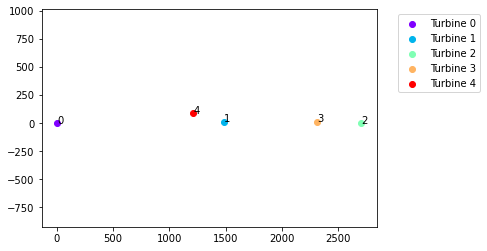

In [174]:
numturb = locsa.shape[0]

cmap = plt.get_cmap('rainbow', numturb)

for i in range(numturb):
    plt.scatter(locsa[i,0], locsa[i,1], color=cmap(i), label='Turbine ' + str(i))

# Set the desired limits for the x and yaxes
plt.xlim(-300, 4500)
plt.ylim(-500, 500)
plt.axis('equal')

# Add labels to each point
for i in range(numturb):
    plt.text(locsa[i, 0], locsa[i, 1], str(i))

# Add legends
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


# Simulation

In [71]:
turbine_coords = np.array(turbine_locations)
sim_number = 6
cfd_simulate.simulate(turbine_coords, sim_number)

Restoring modules from user's mesh
Ignore invalid FOAM_CONFIG_ETC = etc/easybuild


/*---------------------------------------------------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2006                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
Build  : v2006 OPENFOAM=2006
Arch   : "LSB;label=32;scalar=64"
Exec   : blockMesh
Date   : Jul 19 2024
Time   : 11:50:42
Host   : godzilla.csc.warwick.ac.uk
PID    : 32190
I/O    : uncollated
Case   : /home/eng/estrmx/storage/cfd_gp/Mesh_creation
nProcs : 1
trapFpe: Floating point exception trapping enabled (FOAM_SIGFPE).
fileModificationChecking : Monitoring run-time modified files using timeStampMaster (fileModificationSkew 5, maxFile

--> FOAM IOWarning :
    Found [v1012] 'convertToMeters' entry instead of 'scale' in dictionary "/home/eng/estrmx/storage/cfd_gp/Mesh_creation/constant/polyMesh/blockMeshDict" 

    This keyword is deemed to be 114 months old.



Creating points with scale 1
    Block 0 cell size :
        i : 60 .. 60
        j : 24 .. 24
        k : 3.90926 .. 78.1851


There are no merge patch pairs

Writing polyMesh with 0 cellZones
----------------
Mesh Information
----------------
  boundingBox: (-3000 -1200 0) (3000 1200 2000)
  nPoints: 826281
  nCells: 800000
  nFaces: 2426000
  nInternalFaces: 2374000
----------------
Patches
----------------
  patch 0 (start: 2374000 size: 16000) name: frontAndBack
  patch 1 (start: 2390000 size: 8000) name: inlet
  patch 2 (start: 2398000 size: 8000) name: outlet
  patch 3 (start: 2406000 size: 10000) name: ground
  patch 4 (start: 2416000 size: 10000) name: sky

End

/*---------------------------------------------------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2006                                 |




--> FOAM FATAL ERROR: 
Invalid face: less than 3 points. This is not allowed
Face: 2(4761 2060435) faceID:14129 owner:4713 neighbour:4714

    From Foam::polyModifyFace::polyModifyFace(const Foam::face&, Foam::label, Foam::label, Foam::label, bool, Foam::label, bool, Foam::label, bool)
    in file /home/buzz2/pawan/OpenFOAM/Docker/v2006/OpenFOAM-v2006/src/meshTools/lnInclude/polyModifyFace.H at line 135.

FOAM aborting

#0  Foam::error::printStack(Foam::Ostream&) at ??:?
#1  Foam::error::exitOrAbort(int, bool) at ??:?
#2  Foam::polyModifyFace::polyModifyFace(Foam::face const&, int, int, int, bool, int, bool, int, bool) at ??:?
#3  Foam::hexRef8::modFace(Foam::polyTopoChange&, int, Foam::face const&, int, int) const at ??:?
#4  Foam::hexRef8::setRefinement(Foam::List<int> const&, Foam::polyTopoChange&) at ??:?
#5  Foam::meshRefinement::refine(Foam::List<int> const&) at ??:?
#6  Foam::meshRefinement::balanceAndRefine(Foam::string const&, Foam::decompositionMethod&, Foam::fvMeshDistribu

/*---------------------------------------------------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  2112                                  |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
Build  : _14aeaf8dab-20211220 OPENFOAM=2112 version=v2112
Arch   : "LSB;label=32;scalar=64"
Exec   : foamTozCFD
Date   : Jul 19 2024
Time   : 11:51:20
Host   : godzilla.csc.warwick.ac.uk
PID    : 35237
I/O    : uncollated
Case   : /home/eng/estrmx/storage/cfd_gp/Mesh_creation
nProcs : 1
trapFpe: Floating point exception trapping enabled (FOAM_SIGFPE).
fileModificationChecking : Monitoring run-time modified files using timeStampMaster (f

0

In [48]:
turbine_coords = np.array(locga)
sim_number = 14
cfd_simulate.simulate(turbine_coords, sim_number)

Restoring modules from user's mesh
Ignore invalid FOAM_CONFIG_ETC = etc/easybuild


/*---------------------------------------------------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2006                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
Build  : v2006 OPENFOAM=2006
Arch   : "LSB;label=32;scalar=64"
Exec   : blockMesh
Date   : Jul 31 2024
Time   : 16:33:54
Host   : godzilla.csc.warwick.ac.uk
PID    : 288440
I/O    : uncollated
Case   : /home/eng/estrmx/storage/cfd_gp/Mesh_creation
nProcs : 1
trapFpe: Floating point exception trapping enabled (FOAM_SIGFPE).
fileModificationChecking : Monitoring run-time modified files using timeStampMaster (fileModificationSkew 5, maxFil

--> FOAM IOWarning :
    Found [v1012] 'convertToMeters' entry instead of 'scale' in dictionary "/home/eng/estrmx/storage/cfd_gp/Mesh_creation/constant/polyMesh/blockMeshDict" 

    This keyword is deemed to be 114 months old.



Creating points with scale 1
    Block 0 cell size :
        i : 60 .. 60
        j : 24 .. 24
        k : 3.90926 .. 78.1851


There are no merge patch pairs

Writing polyMesh with 0 cellZones
----------------
Mesh Information
----------------
  boundingBox: (-3000 -1200 0) (3000 1200 2000)
  nPoints: 826281
  nCells: 800000
  nFaces: 2426000
  nInternalFaces: 2374000
----------------
Patches
----------------
  patch 0 (start: 2374000 size: 16000) name: frontAndBack
  patch 1 (start: 2390000 size: 8000) name: inlet
  patch 2 (start: 2398000 size: 8000) name: outlet
  patch 3 (start: 2406000 size: 10000) name: ground
  patch 4 (start: 2416000 size: 10000) name: sky

End

/*---------------------------------------------------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2006                                 |


Edge intersection testing:
    Number of edges             : 3650635
    Number of edges to retest   : 1294410
    Number of intersected edges : 0
Refined mesh in = 14.11 s
Determined cells to refine in = 0.09 s
Selected for direction z refinement : 0 cells (out of 1199132)
After directional refinement iteration 0 : cells:1199132  faces:3650635  points:1253059
Cells per refinement level:
    0	800000
    1	399132

Directional shell refinement iteration 1
----------------------------------------

Determined cells to refine in = 0.29 s
Selected for direction x refinement : 405208 cells (out of 1199132)
Edge intersection testing:
    Number of edges             : 4892937
    Number of edges to retest   : 2534834
    Number of intersected edges : 0
Refined mesh in = 25.54 s
Determined cells to refine in = 0.49 s
Selected for direction y refinement : 808864 cells (out of 1604340)
Edge intersection testing:
    Number of edges             : 7343972
    Number of edges to retest   : 4983843
 

For cellZone none found point (0 0 63.3) in global region 0 out of 1 regions.

Remove unreachable sections of mesh
-----------------------------------

Split mesh in = 2.76 s


After subsetting : cells:3416087  faces:10414919  points:3584704
Cells per refinement level:
    0	780908
    1	14475
    2	47999
    3	1508633
    4	69541
    5	994531

Merge free-standing baffles
---------------------------

freeStandingBaffles : detected 0 free-standing baffles out of 0

Detected free-standing baffles : 0
Merged free-standing baffles in = 0.06 s


dupNonManifoldPoints : Found : 0 non-manifold points (out of 3584704)
Detected unsplittable baffles : 0

Merge refined boundary faces
----------------------------

Merging 0 sets of faces.

No faces merged ...

Merging all points on surface that
- are used by only two boundary faces and
- make an angle with a cosine of more than 0.707107.

No straight edges simplified and no points removed ...
Refined mesh : cells:3416087  faces:10414919  points:358

0

In [68]:
turbine_coords = np.array(locpso)
sim_number = 12
cfd_simulate.simulate(turbine_coords, sim_number)

Restoring modules from user's mesh
Ignore invalid FOAM_CONFIG_ETC = etc/easybuild


/*---------------------------------------------------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2006                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
Build  : v2006 OPENFOAM=2006
Arch   : "LSB;label=32;scalar=64"
Exec   : blockMesh
Date   : Jul 27 2024
Time   : 11:49:28
Host   : godzilla.csc.warwick.ac.uk
PID    : 2362298
I/O    : uncollated
Case   : /storage/eng/estrmx/cfd_gp/Mesh_creation
nProcs : 1
trapFpe: Floating point exception trapping enabled (FOAM_SIGFPE).
fileModificationChecking : Monitoring run-time modified files using timeStampMaster (fileModificationSkew 5, maxFileMod

--> FOAM IOWarning :
    Found [v1012] 'convertToMeters' entry instead of 'scale' in dictionary "/storage/eng/estrmx/cfd_gp/Mesh_creation/constant/polyMesh/blockMeshDict" 

    This keyword is deemed to be 114 months old.



Creating points with scale 1
    Block 0 cell size :
        i : 60 .. 60
        j : 24 .. 24
        k : 3.90926 .. 78.1851


There are no merge patch pairs

Writing polyMesh with 0 cellZones
----------------
Mesh Information
----------------
  boundingBox: (-3000 -1200 0) (3000 1200 2000)
  nPoints: 826281
  nCells: 800000
  nFaces: 2426000
  nInternalFaces: 2374000
----------------
Patches
----------------
  patch 0 (start: 2374000 size: 16000) name: frontAndBack
  patch 1 (start: 2390000 size: 8000) name: inlet
  patch 2 (start: 2398000 size: 8000) name: outlet
  patch 3 (start: 2406000 size: 10000) name: ground
  patch 4 (start: 2416000 size: 10000) name: sky

End

/*---------------------------------------------------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2006                                 |


Determined cells to refine in = 0.23 s
Selected for direction x refinement : 315023 cells (out of 1108013)
Edge intersection testing:
    Number of edges             : 4326676
    Number of edges to retest   : 1946854
    Number of intersected edges : 0
Refined mesh in = 20.81 s
Determined cells to refine in = 0.39 s
Selected for direction y refinement : 629271 cells (out of 1423036)
Edge intersection testing:
    Number of edges             : 6232074
    Number of edges to retest   : 3850729
    Number of intersected edges : 0
Refined mesh in = 39.44 s
Determined cells to refine in = 0.13 s
Selected for direction z refinement : 0 cells (out of 2052307)
After directional refinement iteration 1 : cells:2052307  faces:6232074  points:2128141
Cells per refinement level:
    0	812204
    1	1240103

Directional shell refinement iteration 2
----------------------------------------

Determined cells to refine in = 0.44 s
Selected for direction x refinement : 65299 cells (out of 2052307)
Edge 

    faces with face-decomposition tet quality < 1e-30      : 0
    faces with concavity > 80  degrees                     : 0
    faces with skewness > 4   (internal) or 20  (boundary) : 0
    faces with interpolation weights (0..1)  < 0.05        : 0
    faces with volume ratio of neighbour cells < 0.01      : 0
    faces with face twist < 0.05                           : 0
    faces on cells with determinant < 0.001                : 0
Finished meshing with 1065 illegal faces (concave, zero area or negative cell pyramid volume)
Finished meshing in = 314.21 s.
End

/*---------------------------------------------------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  2112                                  |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  

0

In [62]:
turbine_coords = np.array(locsa)
sim_number = 9
cfd_simulate.simulate(turbine_coords, sim_number)

Restoring modules from user's mesh
Ignore invalid FOAM_CONFIG_ETC = etc/easybuild


/*---------------------------------------------------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2006                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
Build  : v2006 OPENFOAM=2006
Arch   : "LSB;label=32;scalar=64"
Exec   : blockMesh
Date   : Jul 23 2024
Time   : 18:44:31
Host   : godzilla.csc.warwick.ac.uk
PID    : 1641870
I/O    : uncollated
Case   : /home/eng/estrmx/storage/cfd_gp/Mesh_creation
nProcs : 1
trapFpe: Floating point exception trapping enabled (FOAM_SIGFPE).
fileModificationChecking : Monitoring run-time modified files using timeStampMaster (fileModificationSkew 5, maxFi

--> FOAM IOWarning :
    Found [v1012] 'convertToMeters' entry instead of 'scale' in dictionary "/home/eng/estrmx/storage/cfd_gp/Mesh_creation/constant/polyMesh/blockMeshDict" 

    This keyword is deemed to be 114 months old.



Creating points with scale 1
    Block 0 cell size :
        i : 60 .. 60
        j : 24 .. 24
        k : 3.90926 .. 78.1851


There are no merge patch pairs

Writing polyMesh with 0 cellZones
----------------
Mesh Information
----------------
  boundingBox: (-3000 -1200 0) (3000 1200 2000)
  nPoints: 826281
  nCells: 800000
  nFaces: 2426000
  nInternalFaces: 2374000
----------------
Patches
----------------
  patch 0 (start: 2374000 size: 16000) name: frontAndBack
  patch 1 (start: 2390000 size: 8000) name: inlet
  patch 2 (start: 2398000 size: 8000) name: outlet
  patch 3 (start: 2406000 size: 10000) name: ground
  patch 4 (start: 2416000 size: 10000) name: sky

End

/*---------------------------------------------------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2006                                 |


Determined cells to refine in = 0.17 s
Selected for direction x refinement : 160990 cells (out of 958170)
Edge intersection testing:
    Number of edges             : 3407638
    Number of edges to retest   : 1011689
    Number of intersected edges : 0
Refined mesh in = 12.31 s
Determined cells to refine in = 0.22 s
Selected for direction y refinement : 320769 cells (out of 1119160)
Edge intersection testing:
    Number of edges             : 4380283
    Number of edges to retest   : 1982510
    Number of intersected edges : 0
Refined mesh in = 21.6 s
Determined cells to refine in = 0.1 s
Selected for direction z refinement : 0 cells (out of 1439929)
After directional refinement iteration 1 : cells:1439929  faces:4380283  points:1501152
Cells per refinement level:
    0	817588
    1	622341

Directional shell refinement iteration 2
----------------------------------------

Determined cells to refine in = 0.24 s
Selected for direction x refinement : 34203 cells (out of 1439929)
Edge inte

dupNonManifoldPoints : Found : 0 non-manifold points (out of 2050281)
Detected unsplittable baffles : 0

Merge refined boundary faces
----------------------------

Merging 0 sets of faces.

No faces merged ...

Merging all points on surface that
- are used by only two boundary faces and
- make an angle with a cosine of more than 0.707107.

No straight edges simplified and no points removed ...
Refined mesh : cells:1955376  faces:5959848  points:2050281
Cells per refinement level:
    0	791758
    1	6519
    2	22492
    3	587173
    4	50318
    5	497116
Writing mesh to time 1
Wrote mesh in = 1.37 s.
Mesh refined in = 203.11 s.
Checking final mesh ...
Checking faces in error :
    non-orthogonality > 65  degrees                        : 1016
    faces with face pyramid volume < 1e-13                 : 0
    faces with face-decomposition tet quality < 1e-30      : 0
    faces with concavity > 80  degrees                     : 0
    faces with skewness > 4   (internal) or 20  (boundary) : 

0

In [77]:
turbine_coords = np.array(hpg_solution)
sim_number = 9
cfd_simulate.simulate(turbine_coords, sim_number)

mkdir: cannot create directory ‘simulation/0004’: File exists
Restoring modules from user's mesh
Ignore invalid FOAM_CONFIG_ETC = etc/easybuild


/*---------------------------------------------------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2006                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
Build  : v2006 OPENFOAM=2006
Arch   : "LSB;label=32;scalar=64"
Exec   : blockMesh
Date   : Jul 19 2024
Time   : 12:38:35
Host   : godzilla.csc.warwick.ac.uk
PID    : 307200
I/O    : uncollated
Case   : /home/eng/estrmx/storage/cfd_gp/Mesh_creation
nProcs : 1
trapFpe: Floating point exception trapping enabled (FOAM_SIGFPE).
fileModificationChecking : Monitoring run-time modified files using timeStampMaster (fileModificationSkew 5, maxFil

--> FOAM IOWarning :
    Found [v1012] 'convertToMeters' entry instead of 'scale' in dictionary "/home/eng/estrmx/storage/cfd_gp/Mesh_creation/constant/polyMesh/blockMeshDict" 

    This keyword is deemed to be 114 months old.



Creating points with scale 1
    Block 0 cell size :
        i : 60 .. 60
        j : 24 .. 24
        k : 3.90926 .. 78.1851


There are no merge patch pairs

Writing polyMesh with 0 cellZones
----------------
Mesh Information
----------------
  boundingBox: (-3000 -1200 0) (3000 1200 2000)
  nPoints: 826281
  nCells: 800000
  nFaces: 2426000
  nInternalFaces: 2374000
----------------
Patches
----------------
  patch 0 (start: 2374000 size: 16000) name: frontAndBack
  patch 1 (start: 2390000 size: 8000) name: inlet
  patch 2 (start: 2398000 size: 8000) name: outlet
  patch 3 (start: 2406000 size: 10000) name: ground
  patch 4 (start: 2416000 size: 10000) name: sky

End

/*---------------------------------------------------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2006                                 |


Edge intersection testing:
    Number of edges             : 3268824
    Number of edges to retest   : 886904
    Number of intersected edges : 0
Refined mesh in = 10.94 s
Determined cells to refine in = 0.07 s
Selected for direction z refinement : 0 cells (out of 1075308)
After directional refinement iteration 0 : cells:1075308  faces:3268824  points:1118737
Cells per refinement level:
    0	798187
    1	277121

Directional shell refinement iteration 1
----------------------------------------

Determined cells to refine in = 0.26 s
Selected for direction x refinement : 282012 cells (out of 1075308)
Edge intersection testing:
    Number of edges             : 4130751
    Number of edges to retest   : 1750765
    Number of intersected edges : 0
Refined mesh in = 18.8 s
Determined cells to refine in = 0.37 s
Selected for direction y refinement : 562033 cells (out of 1357320)
Edge intersection testing:
    Number of edges             : 5833949
    Number of edges to retest   : 3451455
   

For cellZone none found point (0 0 63.3) in global region 0 out of 1 regions.

Remove unreachable sections of mesh
-----------------------------------

Split mesh in = 2.21 s


After subsetting : cells:2919599  faces:8897481  points:3059904
Cells per refinement level:
    0	787049
    1	8837
    2	29564
    3	1030215
    4	69465
    5	994469

Merge free-standing baffles
---------------------------

freeStandingBaffles : detected 0 free-standing baffles out of 0

Detected free-standing baffles : 0
Merged free-standing baffles in = 0.06 s


dupNonManifoldPoints : Found : 0 non-manifold points (out of 3059904)
Detected unsplittable baffles : 0

Merge refined boundary faces
----------------------------

Merging 0 sets of faces.

No faces merged ...

Merging all points on surface that
- are used by only two boundary faces and
- make an angle with a cosine of more than 0.707107.

No straight edges simplified and no points removed ...
Refined mesh : cells:2919599  faces:8897481  points:305990

0

In [ ]:
# 123 120 121
# G4-G6 -- G4. highlight points; g2-G6 -- THREE -> 0.1 NOT WORTH LEARNING coverages included